- Wine, Irises
- 3D to rotate
- Many errors
    - Ларс/лассо
    - Набор признаков оптимальный - фиксируем количество
    - Построить два графика - при всех n могут быть колебания, при оптимальном - плато

In [1]:
import os

import numpy as np
import pandas as pd

import utils_ss as ut
import m_models as mm

from tqdm import tqdm_notebook as tqdm
import ipyvolume as ipv

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d    

# %matplotlib notebook

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

In [5]:
def set_plt_params():
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['lines.markersize'] = 12
    plt.rcParams['xtick.labelsize'] = 24
    plt.rcParams['ytick.labelsize'] = 24
    plt.rcParams['legend.fontsize'] = 40
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['figure.figsize'] = (21.0, 13.0)
    plt.rcParams['font.size'] = 40

In [6]:
labels_for_plot = {
                    'cross': "$\mathsf{E}_{\mathfrak{D}_m}RS(m)$",
                    'apvc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{D}[\hat{w}|\mathfrak{D}_m]$",
                    'acc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{P}\{w \in A_{l}(\hat{w})\}$",
                    'alc': "$\mathsf{E}_{\mathfrak{D}_m}r_m$",
                    'maxu': "$\mathsf{E}_{\mathfrak{D}_m}\int_{w}u(\mathfrak{D}_m, w)p(w|\mathfrak{D}_m)dw$",
                    'kl': "$\mathsf{E}_{\mathfrak{D}_m}D_{KL}(p_1, p_2)$",
                    'bootstrap': "$\mathsf{E}_{\mathfrak{D}_m}$",
                    }

## Boston dataset

In [7]:
name = 'boston'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

(506, 12)


### Observation of model weights

In [8]:
boston_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [9]:
len(boston_df)

506

In [10]:
def test_linear_model_weights(data, init_size, step, num_of_tests=1):        
    weights = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
        weights[0].append(model.coef_)
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        weights.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
            weights[k+1].append(model.coef_)
            
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(weights), x

In [11]:
boston_weights, x = test_linear_model_weights(boston_df, 1, 5, num_of_tests=50)

/Users/xtonev/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
set_plt_params()

/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


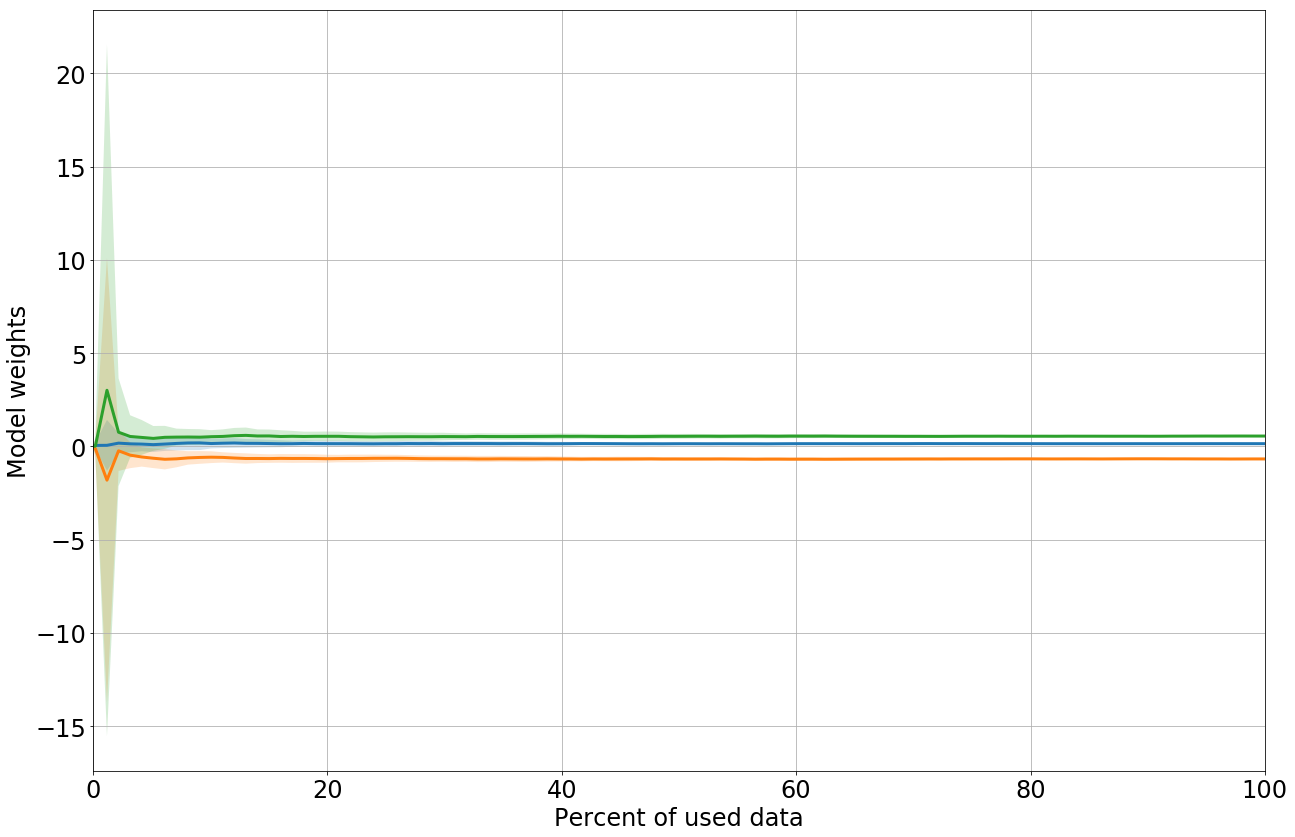

In [13]:
chosen_weights = [3,6,7]
    
mean = np.mean(boston_weights, axis=1)
std = np.std(boston_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [14]:
def test_linear_model_error(data, init_size, step, test_data, num_of_tests=1):    
    error = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
        error[0].append(mean_squared_error(model.predict(test_data.iloc[:,:-1]), test_data.iloc[:,-1]))
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
            error[k+1].append(mean_squared_error(model.predict(test_data.iloc[:,:-1]), test_data.iloc[:,-1]))
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(error), x

In [15]:
boston_train = boston_df.sample(400, random_state=42)
boston_test = boston_df.loc[~boston_df.index.isin(boston_train.index)]

In [16]:
boston_error, x = test_linear_model_error(boston_train, 1, 5, boston_test, num_of_tests=50)

In [17]:
set_plt_params()

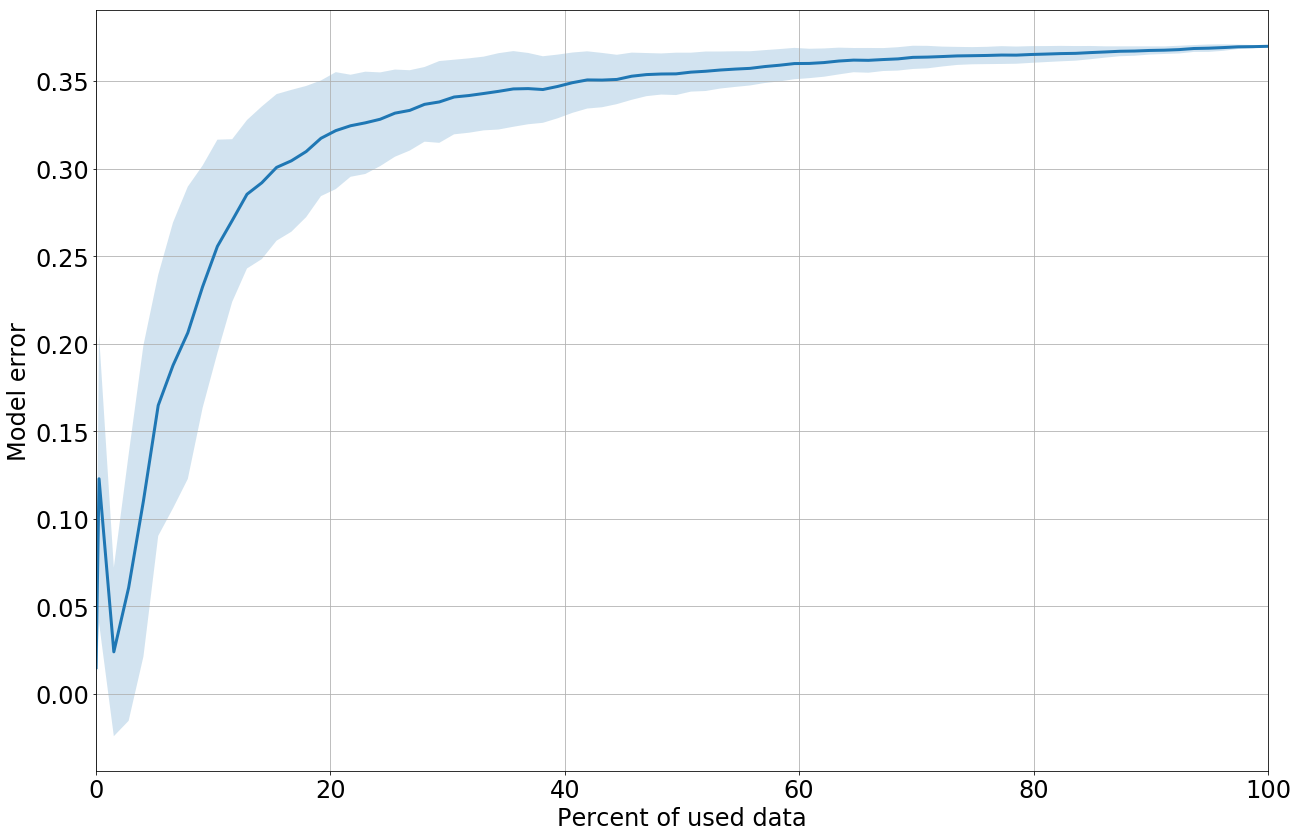

In [18]:
mean = np.mean(np.exp(-boston_error), axis=1)
std = np.std(np.exp(-boston_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [ ]:
def test_linear_model_error_features(data, train_data, test_data, init_size, step, num_of_tests=1):  
    model = ut.LinearModel(data.iloc[:,-1], data.iloc[:,:-1])
    w = model.fit()
    features_order = np.absolute(w).argsort()[::-1].values
    
    answer = [len(features_order)]
    
    error = [[]]
    
    train_data_sampled = []
    chosen_data = []
    for l in range(1, len(features_order)+1):
        train_data_sampled.append([])
        chosen_data.append([])
        error[0].append([])
        
        for i in range(num_of_tests):
            train_data_sampled[l-1].append(train_data.iloc[:,list(features_order[:l])+answer]
                                           .sample(n=init_size, random_state=i))
            chosen_data[l-1].append(np.array(train_data_sampled[l-1][i].index))

            model = LinearRegression().fit(train_data_sampled[l-1][i].iloc[:,:-1], 
                                           train_data_sampled[l-1][i].iloc[:,-1])
            w = model.coef_
            error[0][l-1].append(mean_squared_error(model.predict(test_data.iloc[:,features_order[:l]]), 
                                                    test_data.iloc[:,-1]))
    
    size = [0]
    for k, j in enumerate(range(init_size+step, len(train_data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(train_data)-j)
        for l in range(1, len(features_order)+1):
            error[k+1].append([])
            
            for i in range(num_of_tests):
                add_data = (train_data
                            .iloc[:,list(features_order[:l])+answer]
                            .loc[~train_data.iloc[:,list(features_order[:l])+answer].index.isin(chosen_data[l-1][i])]
                            .sample(n=sample_size, random_state=i)
                           )
                train_data_sampled[l-1][i] = pd.concat((train_data_sampled[l-1][i], add_data))
                chosen_data[l-1][i] = np.concatenate((chosen_data[l-1][i], add_data.index))

                model = LinearRegression().fit(train_data_sampled[l-1][i].iloc[:,:-1], 
                                               train_data_sampled[l-1][i].iloc[:,-1])
                w = model.coef_
                error[k+1][l-1].append(mean_squared_error(model.predict(test_data.iloc[:,features_order[:l]]),
                                                          test_data.iloc[:,-1]))
                                       
        size.append(j)
     
    features = list(range(1,len(features_order)+1))
    return np.array(error), features, size

In [ ]:
boston_error, features, size = test_linear_model_error_features(boston_df, boston_train, boston_test, 
                                                                1, 5, num_of_tests=50)

In [ ]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

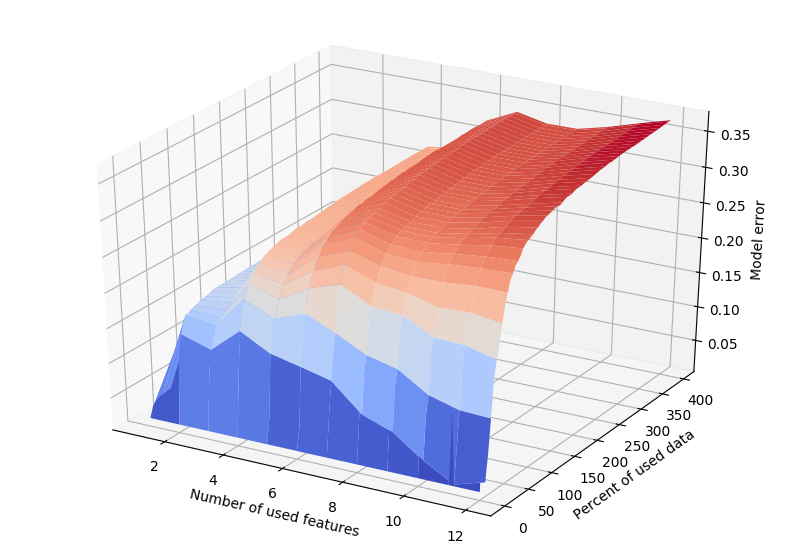

In [ ]:
mean = np.mean(np.exp(-boston_error), axis=2)
std = np.std(np.exp(-boston_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

In [ ]:
colormap = cm.coolwarm 
mean_norm = mean - mean.min()
mean_norm /= mean_norm.ptp() 
mean_norm.min(), mean_norm.max() 
color = colormap(mean_norm)

In [ ]:
ipv.figure(width=700, height=700)

ipv.plot_mesh(xv, yv, mean, color=color[...,:3], wireframe=False)

ipv.pylab.xlabel("Number of used features")
ipv.pylab.ylabel("Percent of used data")
ipv.pylab.zlabel("Model error")
ipv.show()

ipv.pylab.save('boston_error.html', offline=True)

## Servo dataset

In [ ]:
name = 'servo'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

(167, 5)


### Observation of model weights

In [ ]:
servo_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [ ]:
servo_df.shape

(167, 6)

In [ ]:
servo_weights, x = test_linear_model_weights(servo_df, 1, 5, num_of_tests=50)

In [ ]:
set_plt_params()

/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


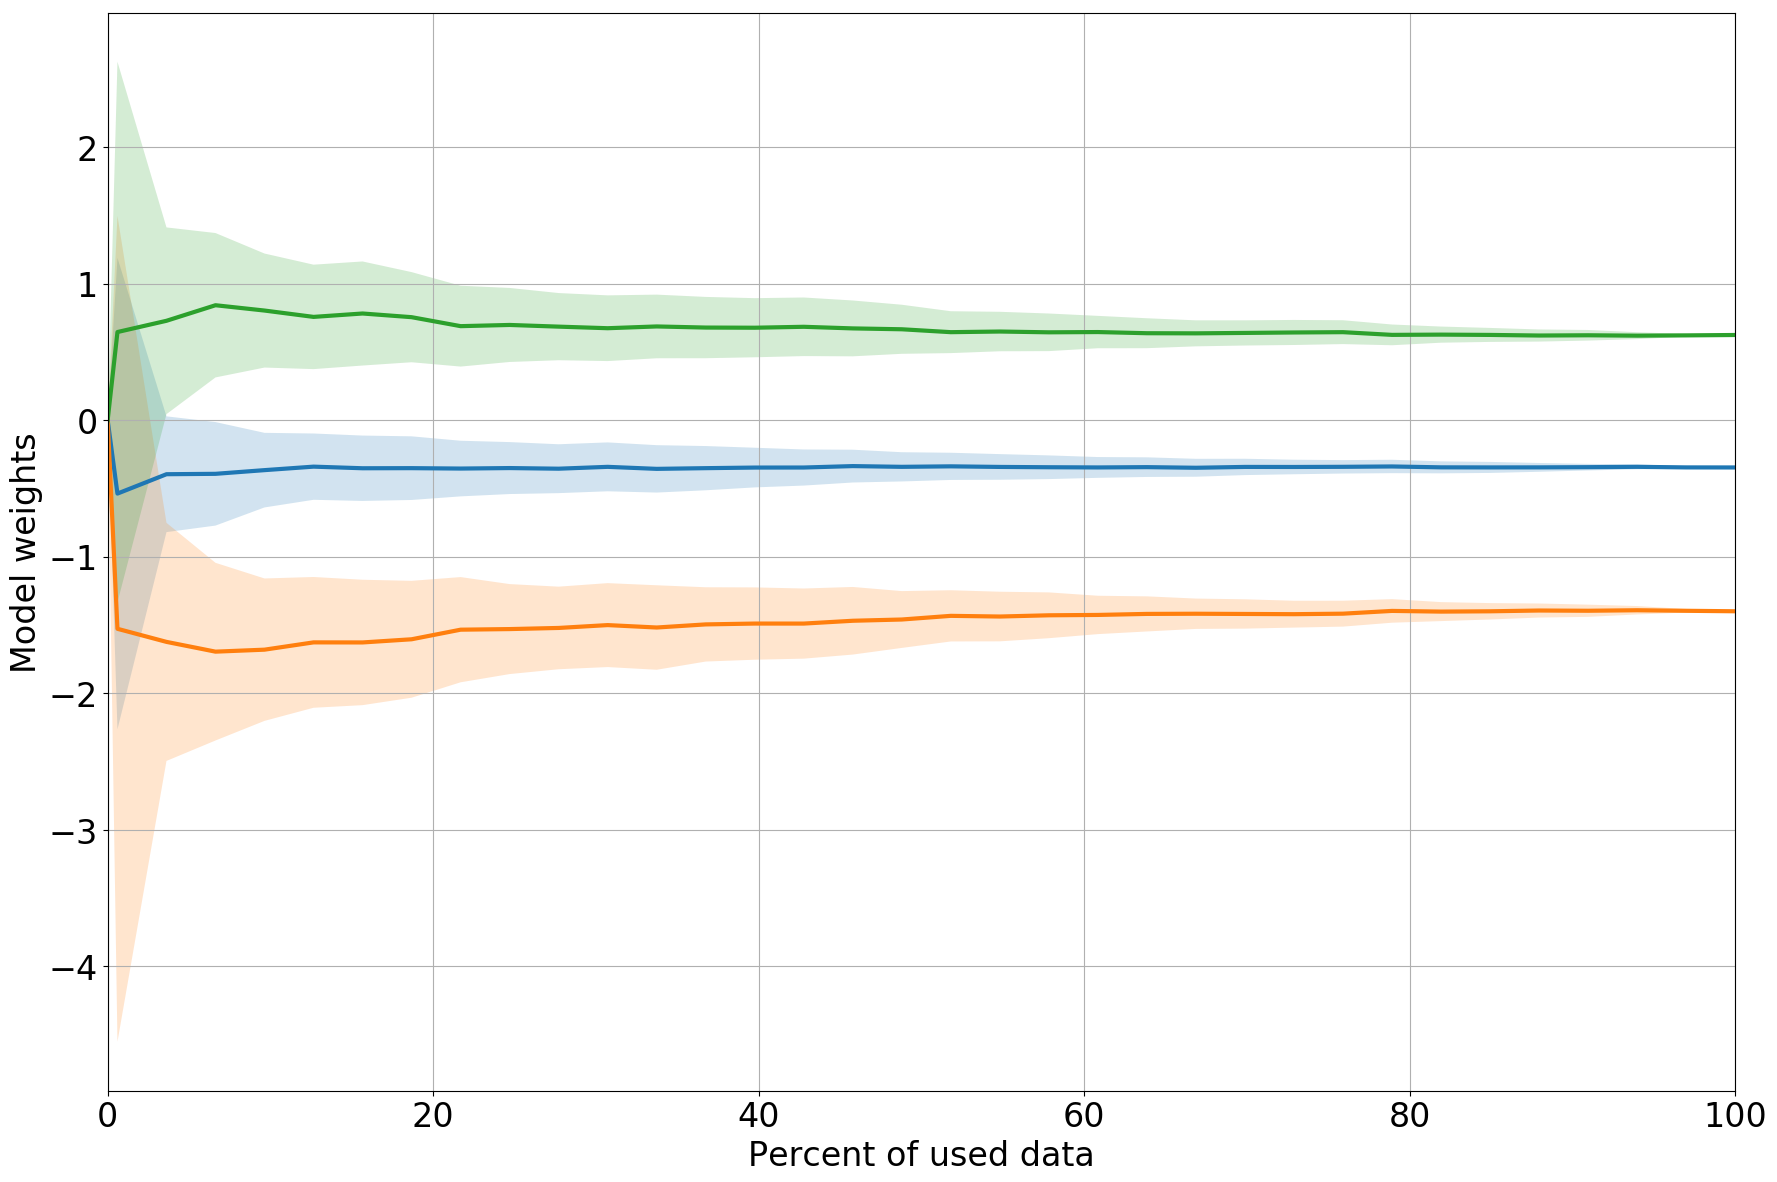

In [ ]:
chosen_weights = [2,3,4]
    
mean = np.mean(servo_weights, axis=1)
std = np.std(servo_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [ ]:
servo_train = servo_df.sample(130, random_state=1)
servo_test = servo_df.loc[~servo_df.index.isin(servo_train.index)]

In [ ]:
servo_error, x = test_linear_model_error(servo_train, 1, 5, servo_test, num_of_tests=50)

In [ ]:
set_plt_params()

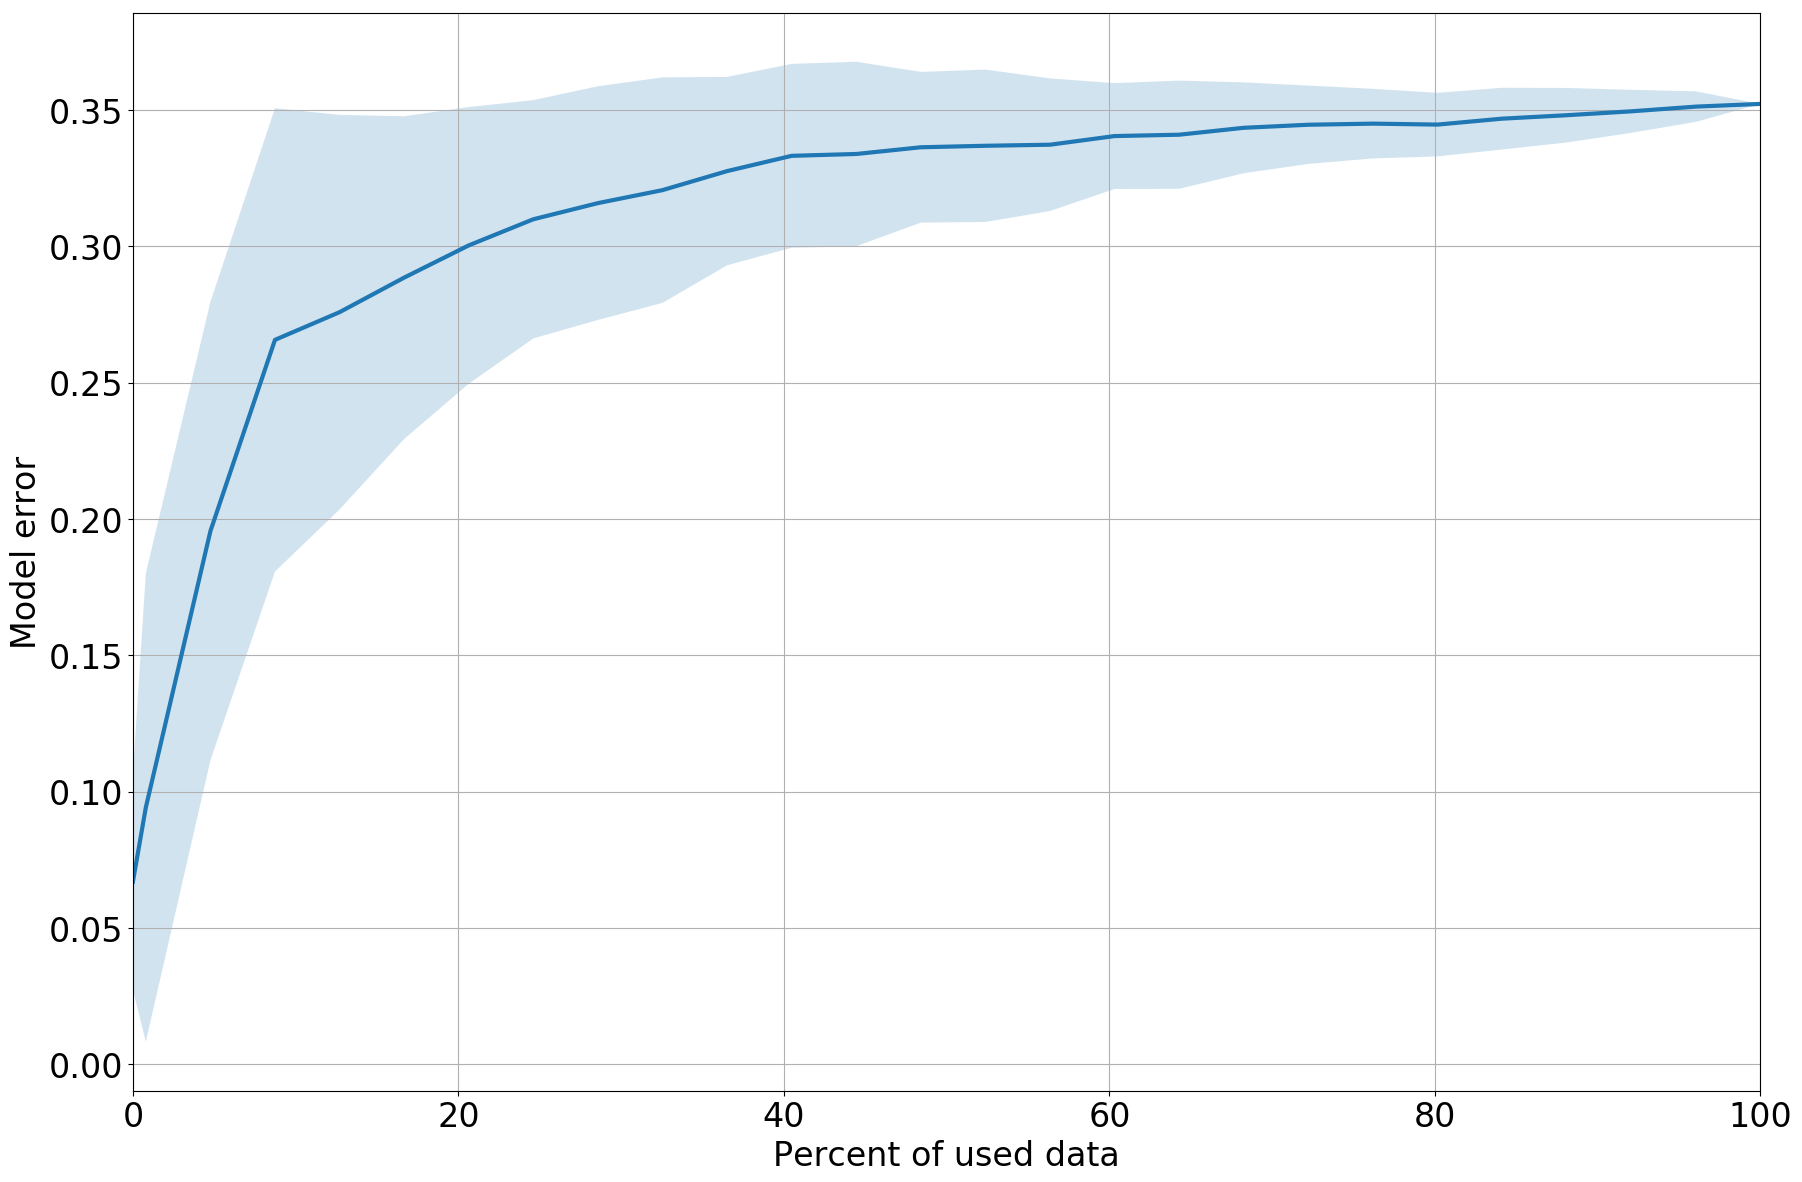

In [ ]:
mean = np.mean(np.exp(-servo_error), axis=1)
std = np.std(np.exp(-servo_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [ ]:
servo_error, features, size = test_linear_model_error_features(servo_df, servo_train, servo_test, 
                                                               1, 5, num_of_tests=50)

In [ ]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

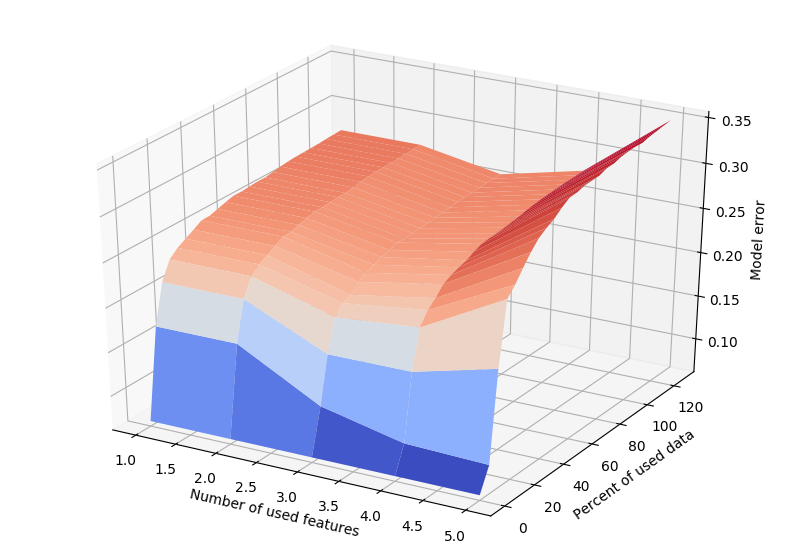

In [ ]:
mean = np.mean(np.exp(-servo_error), axis=2)
std = np.std(np.exp(-servo_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

In [ ]:
colormap = cm.coolwarm 
mean_norm = mean - mean.min()
mean_norm /= mean_norm.ptp() 
mean_norm.min(), mean_norm.max() 
color = colormap(mean_norm)

In [ ]:
ipv.figure(width=700, height=700)

ipv.plot_mesh(xv, yv, mean, color=color[...,:3], wireframe=False)

ipv.pylab.xlabel("Number of used features")
ipv.pylab.ylabel("Percent of used data")
ipv.pylab.zlabel("Model error")
ipv.show()

ipv.pylab.save('servo_error.html', offline=True)

## Sberbank housing dataset

In [ ]:
sberbank_train = pd.read_csv('datasets/housing_train.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_test = pd.read_csv('datasets/housing_test.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_df = pd.concat((sberbank_train, sberbank_test))

X, y = sberbank_train.iloc[:,:-1].values, sberbank_train.iloc[:,-1].values
X, y = ut.preprocess(X, y)

print(X.shape)

(30471, 34)


### Observation of model weights

In [ ]:
sberbank_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [ ]:
sberbank_df.shape

(30471, 35)

In [ ]:
sberbank_weights, x = test_linear_model_weights(sberbank_df, 1, 50, num_of_tests=50)

In [ ]:
set_plt_params()

In [ ]:
np.mean(sberbank_weights, axis=1)[-1]

array([ 0.        ,  0.31321335,  0.09407167,  0.14932793, -0.03369069,
        0.37825945, -0.08966517, -0.16055045,  0.2229132 ,  0.04233351,
        0.69034587, -0.92204739,  0.08731543, -0.06959403, -0.0505381 ,
        0.00709835,  0.03883833, -0.09334761, -0.04592218,  0.07629864,
        0.04975254, -0.06229477,  0.51580547, -0.10255409, -0.37807344,
        0.17178546, -0.82154669,  0.02523473,  0.0948247 , -0.0781674 ,
       -0.13580834,  0.19689361,  0.30138362, -0.08583452])

/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


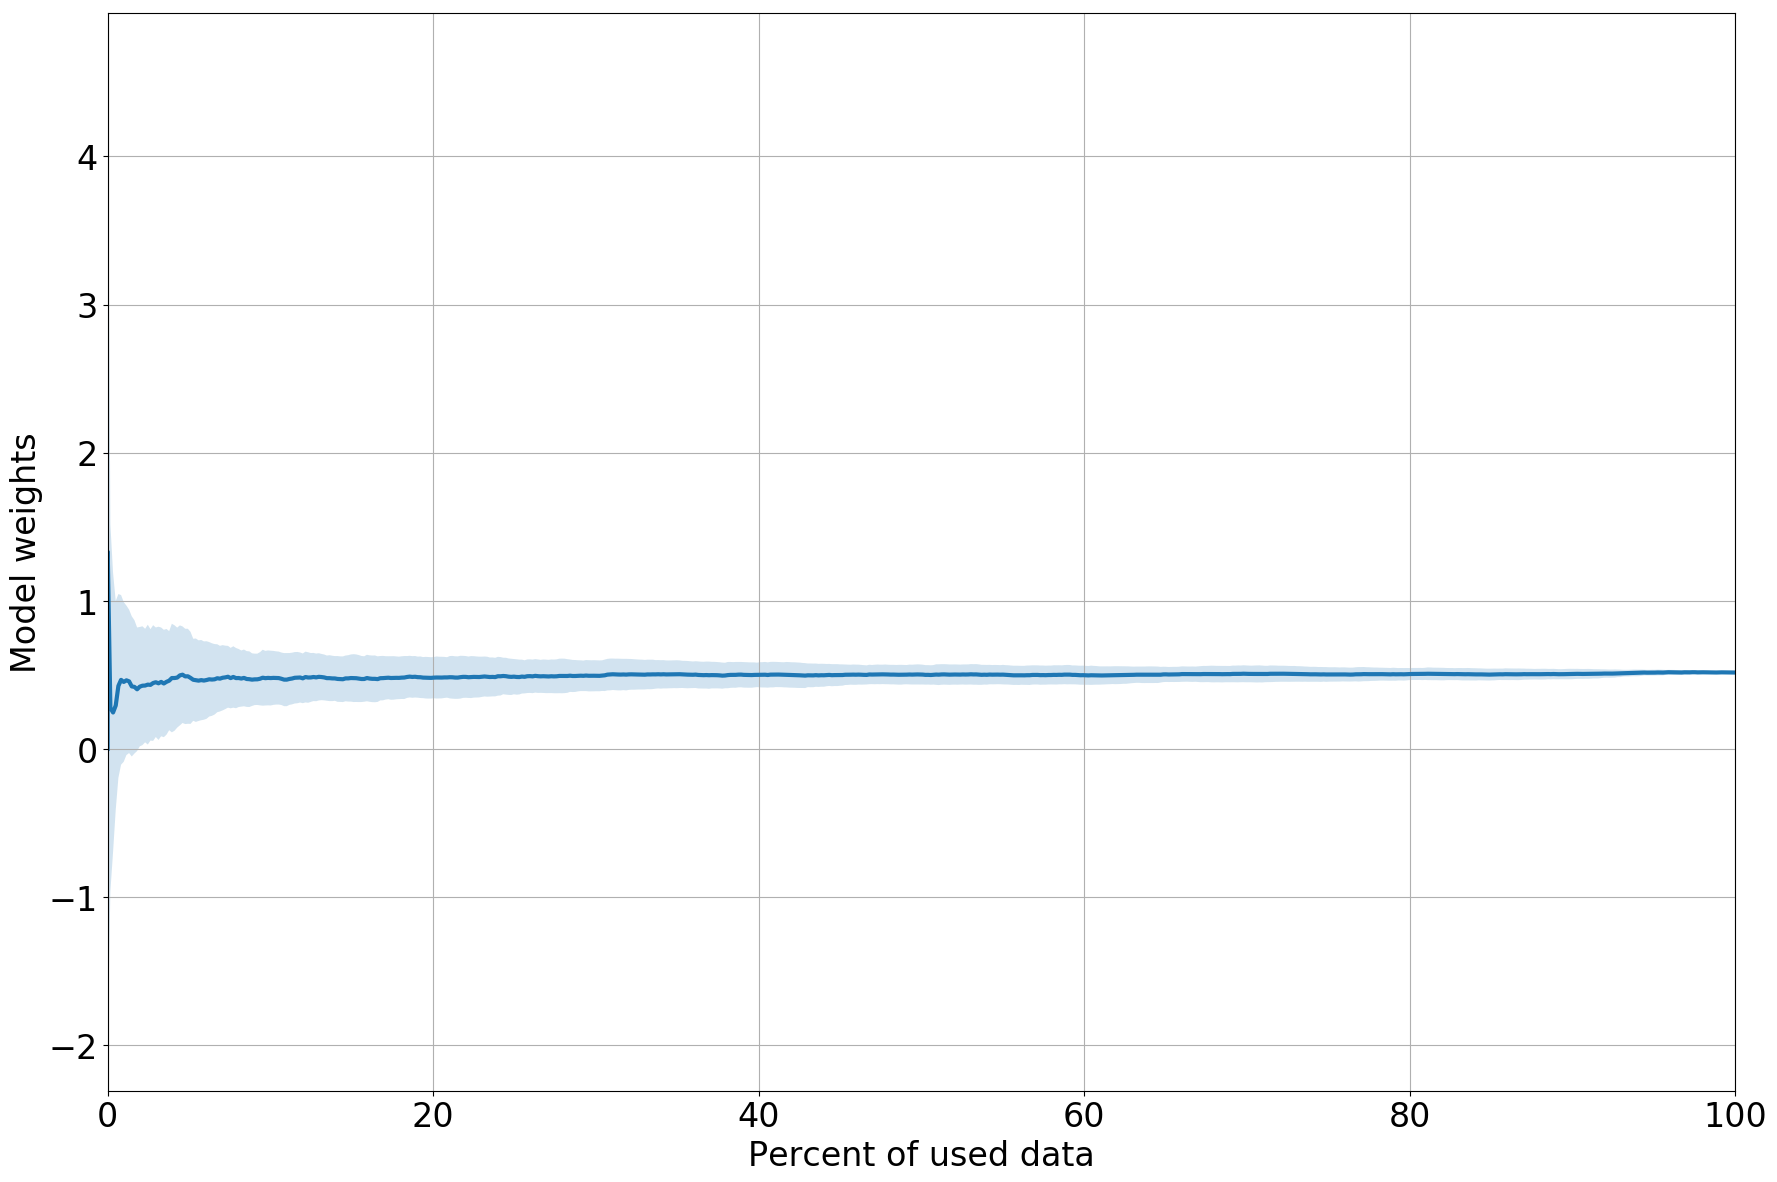

In [ ]:
chosen_weights = [22]
    
mean = np.mean(sberbank_weights, axis=1)
std = np.std(sberbank_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [ ]:
sberbank_train = sberbank_df.sample(30000, random_state=42)
sberbank_test = sberbank_df.loc[~sberbank_df.index.isin(sberbank_train.index)]

In [ ]:
sberbank_error, x = test_linear_model_error(sberbank_train, 1, 50, sberbank_test, num_of_tests=50)

In [ ]:
set_plt_params()

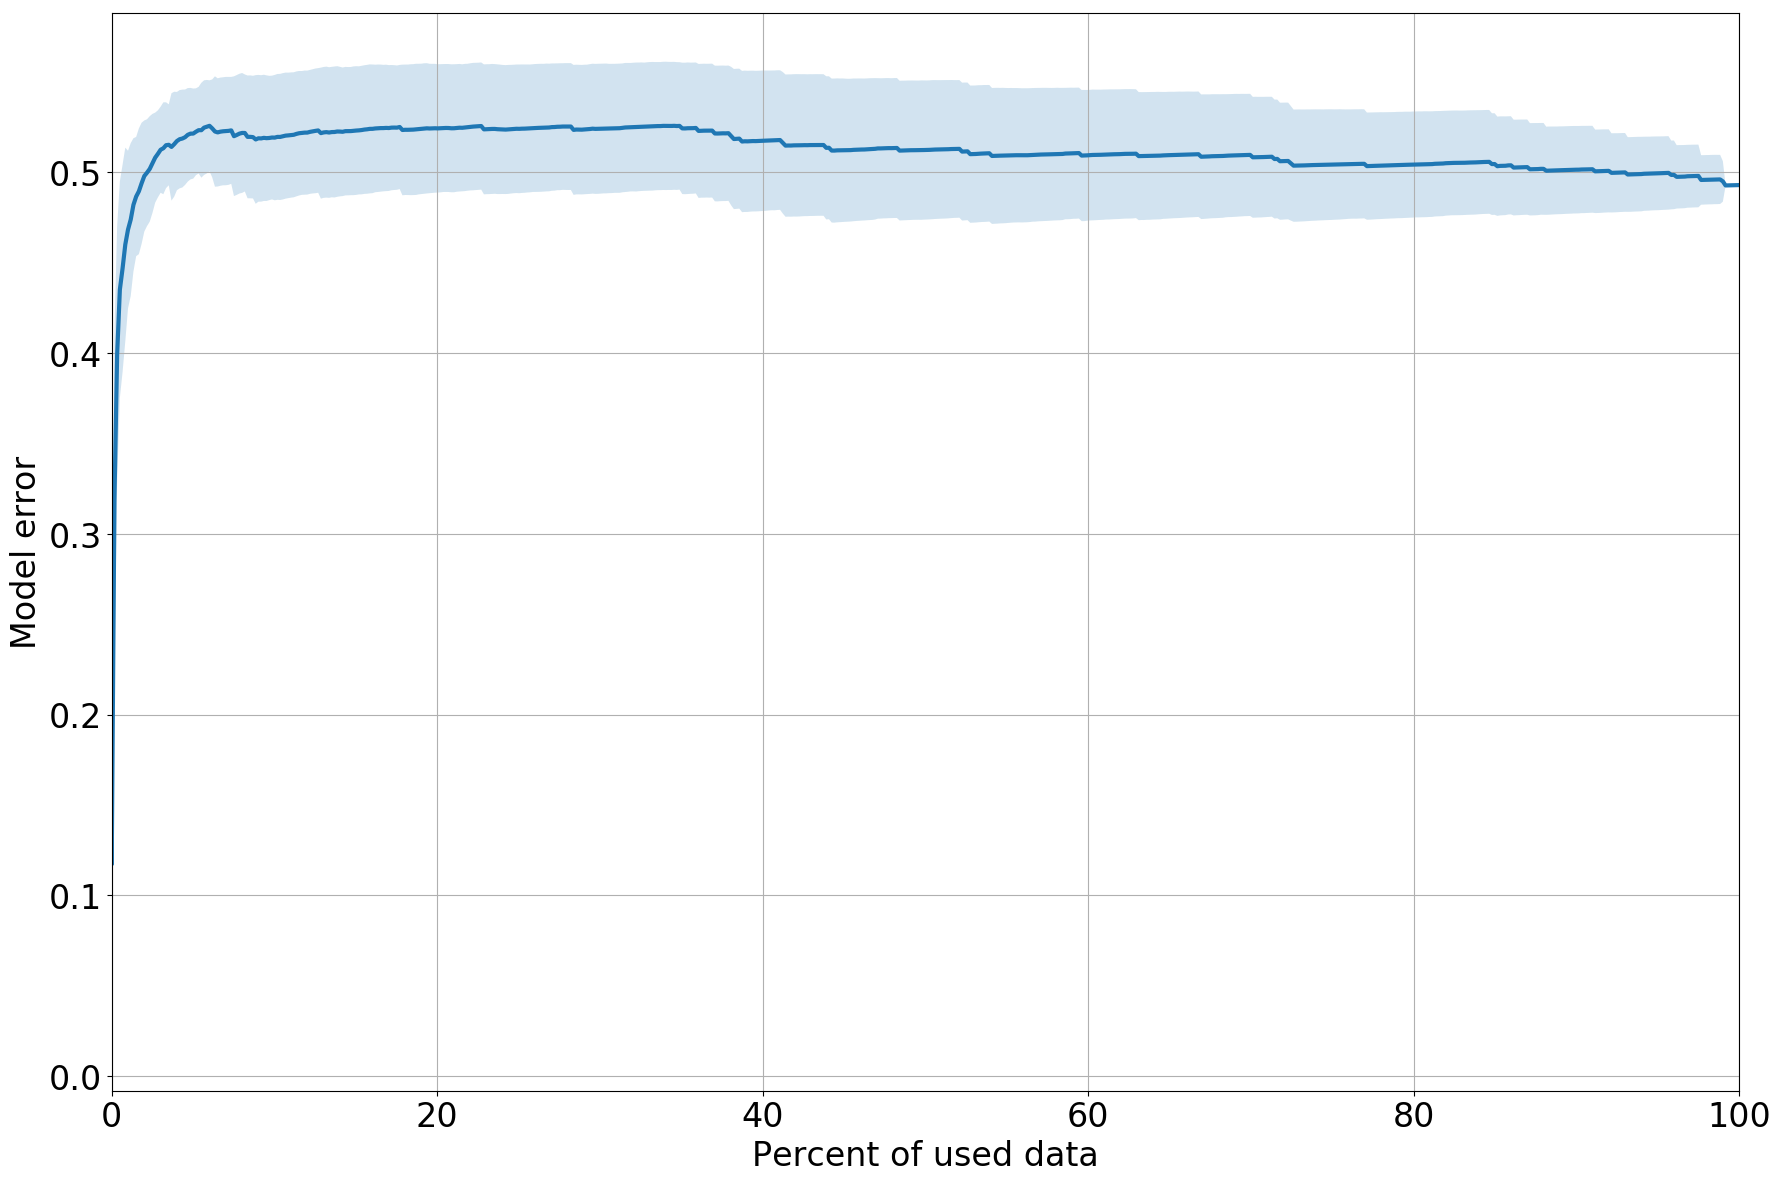

In [ ]:
mean = np.mean(np.exp(-sberbank_error), axis=1)
std = np.std(np.exp(-sberbank_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [53]:
sberbank_error, features, size = test_linear_model_error_features(sberbank_df, sberbank_train, sberbank_test, 
                                                                  1, 500, num_of_tests=5)

In [54]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

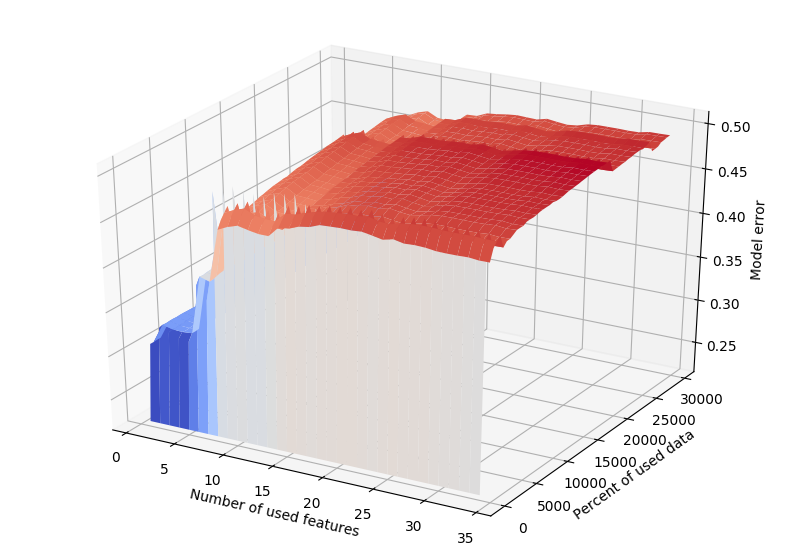

In [55]:
mean = np.mean(np.exp(-sberbank_error), axis=2)
std = np.std(np.exp(-sberbank_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

In [56]:
colormap = cm.coolwarm 
mean_norm = mean - mean.min()
mean_norm /= mean_norm.ptp() 
mean_norm.min(), mean_norm.max() 
color = colormap(mean_norm)

In [57]:
ipv.figure(width=700, height=700)

ipv.plot_mesh(xv, yv, mean, color=color[...,:3], wireframe=False)

ipv.pylab.xlabel("Number of used features")
ipv.pylab.ylabel("Percent of used data")
ipv.pylab.zlabel("Model error")
ipv.show()

ipv.pylab.save('sberbank_error.html', offline=True)